In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import common_functions as cf
import keras_tuner as kt

# from keras import models
# from keras import layers

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# CNN

In [3]:
def MakeModel(class_names: list) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing

    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
    
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()

    def build_model(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Rescaling(1./255))
        for _ in range(1, hp.Int("num_conv_layers", 1, 2)):
            model.add(tf.keras.layers.Conv2D(hp.Int("conv_filters", 16, 28, 8), 3, kernel_regularizer='l2', activation='relu')) # tf.keras.regularizers.L2(hp.Choice("conv_regularizer", values=[1e-2, 1e-3, 1e-4]))
            model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.Flatten())
        for _ in range(1, hp.Int("num_layers", 0, 5)):
            model.add(tf.keras.layers.Dense(hp.Int("units", 32, 512, 32), kernel_regularizer='l2', activation='relu')) # tf.keras.regularizers.L2(hp.Choice("conv_regularizer", values=[1e-2, 1e-3, 1e-4]))
        model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout", 0, 0.5, 0.1)))
        model.add(tf.keras.layers.Dense(len(class_names))) # output

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model
    return build_model
    

## Load Data

In [4]:
if not os.path.exists("../Data/Augmented"):
    cf.AugmentImages()

Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


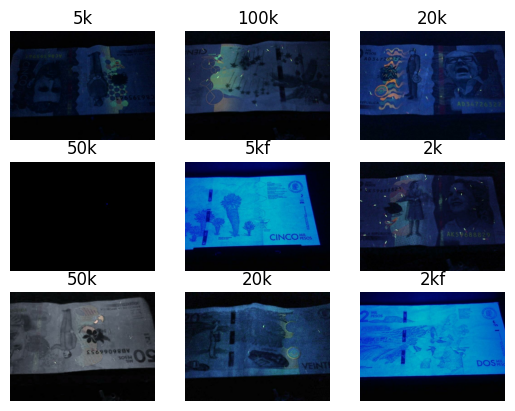

In [5]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=16)
cf.PeakData(train_ds, class_names)

# Run Hyperparameterization

In [21]:
tuner = kt.Hyperband(MakeModel(class_names),
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_logs/cnn',
                     project_name='augmented')
tuner.search(
    train_ds, 
    validation_data=validation_ds, 
    epochs=50, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
""")
best_hps.values

INFO:tensorflow:Reloading Tuner from hp_logs/cnn/augmented/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.



{'num_conv_layers': 2,
 'num_layers': 0,
 'dropout': 0.2,
 'learning_rate': 0.001,
 'conv_filters': 16,
 'units': 256,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

# Find Best Epoch

In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# .map(cf.AugmentImage(contrast=1))
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=15
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/15
1560/1560 [==============================] - 77s 49ms/step - loss: 1.2138 - accuracy: 0.7955 - val_loss: 0.3150 - val_accuracy: 0.9323
Epoch 2/15
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0960 - accuracy: 0.9784 - val_loss: 0.1093 - val_accuracy: 0.9718
Epoch 3/15
1560/1560 [==============================] - 83s 53ms/step - loss: 0.0692 - accuracy: 0.9847 - val_loss: 0.0998 - val_accuracy: 0.9724
Epoch 4/15
1560/1560 [==============================] - 77s 49ms/step - loss: 0.0511 - accuracy: 0.9871 - val_loss: 0.0807 - val_accuracy: 0.9736
Epoch 5/15
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0384 - accuracy: 0.9905 - val_loss: 0.0991 - val_accuracy: 0.9712
Epoch 6/15
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0491 - accuracy: 0.9871 - val_loss: 0.1047 - val_accuracy: 0.9673
Epoch 7/15
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0262 - accuracy: 0.9924 - val_loss: 0.1081 -

# Fit the Best Model

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=best_epoch
)

Epoch 1/13
1560/1560 [==============================] - 77s 49ms/step - loss: 1.8636 - accuracy: 0.8063 - val_loss: 0.2121 - val_accuracy: 0.9493
Epoch 2/13
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0956 - accuracy: 0.9771 - val_loss: 0.1398 - val_accuracy: 0.9637
Epoch 3/13
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0625 - accuracy: 0.9841 - val_loss: 0.0823 - val_accuracy: 0.9738
Epoch 4/13
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0458 - accuracy: 0.9877 - val_loss: 0.0944 - val_accuracy: 0.9698
Epoch 5/13
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0544 - accuracy: 0.9857 - val_loss: 0.0872 - val_accuracy: 0.9732
Epoch 6/13
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0403 - accuracy: 0.9891 - val_loss: 0.1880 - val_accuracy: 0.9438
Epoch 7/13
1560/1560 [==============================] - 76s 49ms/step - loss: 0.0332 - accuracy: 0.9909 - val_loss: 0.1080 -

# Evaluate

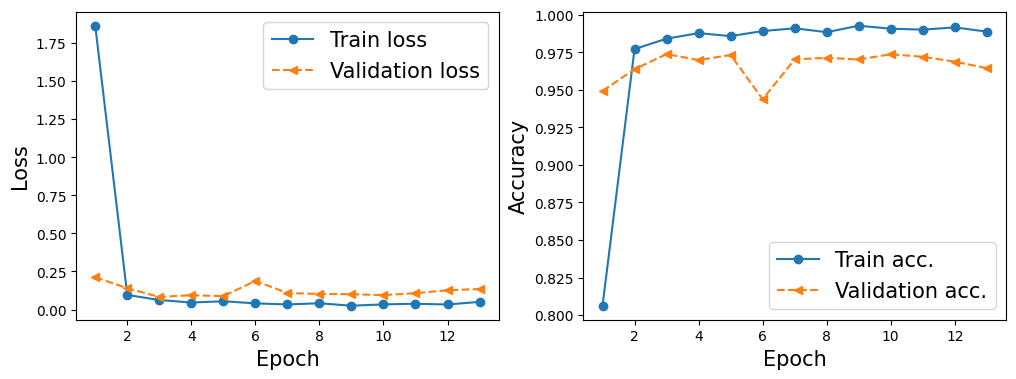

520/520 - 14s - loss: 0.1469 - accuracy: 0.9630 - 14s/epoch - 26ms/step
Test loss: 0.14685741066932678 | Test accuracy: 0.9629807472229004


(0.9887410998344421, 0.9644230604171753, 0.9629807472229004)

In [14]:
cf.EvaluateModel(hypermodel, test_ds, history)

# Results

grayscale, no augmentation, hyperparameterized (no regularization) = 0.995 trained, 0.9957 test

no grayscale, no augmentation, hyperparameterized (regularization) = 0.9885 trained, 0.9567 validation, 0.9596 test

no grayscale, with augmented images, hyperparameterized, no regularization = 0.9887 trained, 0.9644 validation, 0.9630 test

